In [4]:
#Important Libraries
import sys
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

#Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#Data Encoding
from sklearn.preprocessing import  OneHotEncoder

#Preprocessing
from sklearn.preprocessing import StandardScaler

#Classifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
#Synthetic dataset
synth_train = pd.read_csv('/content/drive/MyDrive/Degree Project/train3.zip', delimiter=',')
synth_test = pd.read_csv('/content/drive/MyDrive/Degree Project/test3.zip', delimiter=',')
def data(df1,df2):
  Y1 = df1['Label'].to_numpy()                            #Labels
  Y2 = df1['Label'].to_numpy()
  X1 = df1.to_numpy()
  X2 = df2.to_numpy()
  n  = X1.shape[0]
  X = np.concatenate((X1,X2),axis=0)
  X = np.delete(X, -1, axis=1)
  X1 = X[:,[0,1,3,5]]                                    #Categorical Features
  X2 = X[:, [2,4,6]]                                     #Numerical Features
  X1 = OneHotEncoder().fit_transform(X1).toarray() #Encode categorical features
  X = np.concatenate((X1,X2), axis=1)
  X = StandardScaler().fit_transform(X)            #Standardizes data
  X = np.asarray(X).astype('float32')
  Y1 = np.asarray(Y1).astype('float32')
  Y2 = np.asarray(Y1).astype('float32')
  X1 = X[0:n]
  X2 = X[0:n]
  return X1,X2,Y1,Y2
X_train,X_test,Y_train,Y_test = data(synth_train,synth_test)

In [46]:
#KDD-Cup 99 dataset
KDD_train = pd.read_csv('/content/drive/MyDrive/Degree Project/kddcup.data_10_percent.gz', compression='gzip').dropna() 
KDD_test = pd.read_csv('/content/drive/MyDrive/Degree Project/corrected.gz', compression='gzip').dropna()
KDD_train.columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

KDD_test.columns = KDD_train.columns
#Remove duplicates
KDD_train = KDD_train.drop_duplicates(keep=False)
KDD_test = KDD_test.drop_duplicates(keep=False)
#Change outcome to 0 if normal and 1 if anomalous
KDD_train['outcome'] = (KDD_train['outcome']!='normal.')*1
KDD_test['outcome'] = (KDD_test['outcome']!='normal.')*1
def data(df):
  X = df.to_numpy()
  Y = X[:,-1]
  X = np.delete(X, -1, axis=1)
  X1 = np.array([X[:,0]]).transpose()
  X2 = OneHotEncoder().fit_transform(X[:,1:2]).toarray()
  X3 = X[:,4:]
  X = np.concatenate((X1,X2,X3), axis=1)
  X = np.asarray(X).astype('float32')
  Y = np.asarray(Y).astype('float32')
  X = StandardScaler().fit_transform(X)
  normal_indx = np.where(Y==0)                      #Index of normal observations
  anomaly_indx = np.where(Y==1)                     #Index of anomalies
  X_normal  = X[normal_indx]
  X_anomaly = X[anomaly_indx]
  Y_normal  = Y[normal_indx]
  Y_anomaly = Y[anomaly_indx]
  return X,X_normal,X_anomaly,Y,Y_normal,Y_anomaly

X_train,X_normal_train,X_anomaly_train,Y_train,Y_normal_train,Y_anomaly_train = data(KDD_train)
X_test,X_normal_test,X_anomaly_test,Y_test,Y_normal_test,Y_anomaly_test       = data(KDD_test) 

In [ ]:
class biGAN_Anomaly(keras.Model):
    def __init__(self,data_dim=34,latent_dim=30,init_kernel=keras.initializers.GlorotNormal, init_bias=keras.initializers.constant(0)):
        super(biGAN_Anomaly, self).__init__()
        self.data_dim      = data_dim              #Dimension of data
        self.latent_dim    = latent_dim            #Dimension of latent space
        self.init_kernel   = init_kernel           #Inititialization of weights
        self.init_bias     = init_bias             #Inititialization of bias
        self.encoder       = self.Encoder()        #Encoder network
        self.generator     = self.Generator()      #Generator network
        self.discriminator = self.Discriminator()  #Discriminator network


    def Encoder(self):
      encoder_input   = keras.Input(self.data_dim, name='x') #x
      encoder         = layers.Dense(30, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder_input)
      encoder_output = layers.Dense(self.latent_dim, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder) #E(x)
      return keras.Model(encoder_input,encoder_output, name='Encoder')

    def Generator(self):
      generator_input  = keras.Input(self.latent_dim, name='z') #z
      generator        = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator_input)
      generator        = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator)
      generator_output = layers.Dense(self.data_dim, activation='linear', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator) #G(z)
      return keras.Model(generator_input, generator_output, name='Generator')

    def Discriminator(self):
      x  = keras.Input(self.data_dim)
      z  = keras.Input(self.latent_dim)
      D  = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(tf.concat([x,z],-1))
      D  = layers.Dense(32, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
      D_output = layers.Dense(1, activation='sigmoid', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
      return keras.Model([x,z], D_output, name='Discriminator')

    def compile(self,optimizer = keras.optimizers.Adam(learning_rate=10**-5, beta_1=0.5), loss = keras.losses.BinaryCrossentropy(), train_metric = keras.metrics.BinaryCrossentropy):
      self.optimizer    = optimizer

    #Include only normal samples in X_train
    def train(self, X_train, Epochs, batch_size=50):
      for Epoch in range(Epochs):
        X = tf.data.Dataset.from_tensor_slices(X_train)
        X = X.shuffle(buffer_size=1024).batch(batch_size) #Shuffles data and divides the dataset in batches
        pbar = tqdm(X, position=0, leave=True)            #Progressbar
        for step, x in enumerate(pbar):
          z = tf.random.normal(shape=(x.shape[0], self.latent_dim))     #Sample normal distributed noise
          with tf.GradientTape(persistent=True) as tape:
            x_ = self.generator(z)                                      #Generate x from noise
            z_ = self.encoder(x)                                        #Encode x               
            real_pred = self.discriminator([x,z_])
            fake_pred = self.discriminator([x_,z])
            d_loss = -tf.reduce_mean(tf.math.log(real_pred+1e-7)+tf.math.log(1.0-fake_pred+1e-7)) #Discriminator loss
            g_loss = -tf.reduce_mean(tf.math.log(fake_pred+1e-7)+tf.math.log(1.0-real_pred+1e-7)) #Generator loss
          
          d_gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)               #Discriminator gradients
          self.optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))  #Update Discriminator paramaters
          g_gradients = tape.gradient(g_loss, self.generator.trainable_weights+self.encoder.trainable_weights)  #Generator & Encoder loss
          self.optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights+self.encoder.trainable_weights)) #Update Generator and Encoder parameters
          del tape

          #Update progressbar
          if step % 100 == 0:
            pbar.set_description('Epoch %d of %d | D_loss=%.4f | G_loss=%.4f' % (Epoch+1, Epochs, d_loss, g_loss))

    #Optimizes alpha to maximize F1-score
    #Include normal and anomalous samples in X_train and Y_train
    def optimize_alpha(self,X_train,Y_train):
      BCS = tf.keras.losses.BinaryCrossentropy()
      self.alpha = 0
      F1_max = 0
      pbar = tqdm(np.linspace(0,1,201), position=0, leave=True)
      for alpha in pbar:
        reconstructions = self.generator(self.encoder(X_train))
        L_G = keras.losses.mae(reconstructions, X_train)
        L_D = BCS(tf.ones_like(L_G),self.discriminator([X_train,self.encoder(X_train)]))
        scores = alpha*L_G + (1-alpha)*L_D
        
        #Calculate F1-scores for different thresholds
        precision, recall, thresholds = precision_recall_curve(Y_train, scores)
        indx = np.where(precision==0.)
        precision = np.delete(precision,indx)
        recall = np.delete(recall,indx)
        thresholds = np.delete(thresholds,indx)
        F1_scores  = 2*precision*recall/(precision+recall)
        F1 = np.max(F1_scores)

        #Update self.alpha if current alpha yields a higher F1-score
        if F1 > F1_max:
          F1_max = F1
          self.alpha = alpha
          pbar.set_description('alpha = %d | F1_max = %.4f |' % (alpha, F1_max))

    def score_samples(self, X):
      BCS = tf.keras.losses.BinaryCrossentropy()
      reconstructions = self.generator(self.encoder(X))
      L_G = keras.losses.mae(reconstructions, X)
      L_D = BCS(tf.ones_like(L_G),self.discriminator([X,self.encoder(X)]))
      return self.alpha*L_G+(1-self.alpha)*L_D
        



In [44]:
class biGAN_Anomaly(keras.Model):
    def __init__(self,data_dim=34,latent_dim=20,init_kernel=keras.initializers.GlorotNormal, init_bias=keras.initializers.constant(0)):
        super(biGAN_Anomaly, self).__init__()
        self.data_dim      = data_dim              #Dimension of data
        self.latent_dim    = latent_dim            #Dimension of latent space
        self.init_kernel   = init_kernel           #Inititialization of weights
        self.init_bias     = init_bias             #Inititialization of bias
        self.encoder       = self.Encoder()        #Encoder network
        self.generator     = self.Generator()      #Generator network
        self.discriminator = self.Discriminator()  #Discriminator network


    def Encoder(self):
      encoder_input   = keras.Input(self.data_dim, name='x') #x
      encoder         = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder_input)
      encoder         = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder)
      encoder         = layers.Dense(32, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder)
      encoder_output = layers.Dense(self.latent_dim, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(encoder) #E(x)
      return keras.Model(encoder_input,encoder_output, name='Encoder')

    def Generator(self):
      generator_input  = keras.Input(self.latent_dim, name='z') #z
      generator        = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator_input)
      generator        = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator)
      generator        = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator)
      generator_output = layers.Dense(self.data_dim, activation='linear', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(generator) #G(z)
      return keras.Model(generator_input, generator_output, name='Generator')

    def Discriminator(self):
      x  = keras.Input(self.data_dim)
      z  = keras.Input(self.latent_dim)
      D  = layers.Dense(128, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(tf.concat([x,z],-1))
      D  = layers.Dense(128, activation='linear', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
      D  = layers.Dense(64, activation='relu', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
      D_output = layers.Dense(1, activation='sigmoid', kernel_initializer=self.init_kernel, bias_initializer=self.init_bias)(D)
      return keras.Model([x,z], D_output, name='Discriminator')

    def compile(self,optimizer = keras.optimizers.Adam(learning_rate=10**-5, beta_1=0.5), loss = keras.losses.BinaryCrossentropy(), train_metric = keras.metrics.BinaryCrossentropy):
      self.optimizer    = optimizer

    #Include only normal samples in X_train
    def train(self, X_train, Epochs, batch_size=50):
      for Epoch in range(Epochs):
        X = tf.data.Dataset.from_tensor_slices(X_train)
        X = X.shuffle(buffer_size=1024).batch(batch_size) #Shuffles data and divides the dataset in batches
        pbar = tqdm(X, position=0, leave=True)            #Progressbar
        for step, x in enumerate(pbar):
          z = tf.random.normal(shape=(x.shape[0], self.latent_dim))     #Sample normal distributed noise
          with tf.GradientTape(persistent=True) as tape:
            x_ = self.generator(z)                                      #Generate x from noise
            z_ = self.encoder(x)                                        #Encode x               
            real_pred = self.discriminator([x,z_])
            fake_pred = self.discriminator([x_,z])
            d_loss = -tf.reduce_mean(tf.math.log(real_pred+1e-7)+tf.math.log(1.0-fake_pred+1e-7)) #Discriminator loss
            g_loss = -tf.reduce_mean(tf.math.log(fake_pred+1e-7)+tf.math.log(1.0-real_pred+1e-7)) #Generator loss
          
          d_gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)               #Discriminator gradients
          self.optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_weights))  #Update Discriminator paramaters
          g_gradients = tape.gradient(g_loss, self.generator.trainable_weights+self.encoder.trainable_weights)  #Generator & Encoder loss
          self.optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_weights+self.encoder.trainable_weights)) #Update Generator and Encoder parameters
          del tape

          #Update progressbar
          if step % 100 == 0:
            pbar.set_description('Epoch %d of %d | D_loss=%.4f | G_loss=%.4f' % (Epoch+1, Epochs, d_loss, g_loss))

    #Optimizes alpha to maximize F1-score
    #Include normal and anomalous samples in X_train and Y_train
    def optimize_alpha(self,X_train,Y_train):
      BCS = tf.keras.losses.BinaryCrossentropy()
      self.alpha = 0
      F1_max = 0
      pbar = tqdm(np.linspace(0,1,201), position=0, leave=True)
      for alpha in pbar:
        reconstructions = self.generator(self.encoder(X_train))
        L_G = keras.losses.mae(reconstructions, X_train)
        L_D = BCS(tf.ones_like(L_G),self.discriminator([X_train,self.encoder(X_train)]))
        scores = alpha*L_G + (1-alpha)*L_D
        
        #Calculate F1-scores for different thresholds
        precision, recall, thresholds = precision_recall_curve(Y_train, scores)
        indx = np.where(precision==0.)
        precision = np.delete(precision,indx)
        recall = np.delete(recall,indx)
        thresholds = np.delete(thresholds,indx)
        F1_scores  = 2*precision*recall/(precision+recall)
        F1 = np.max(F1_scores)

        #Update self.alpha if current alpha yields a higher F1-score
        if F1 > F1_max:
          F1_max = F1
          self.alpha = alpha
          pbar.set_description('alpha = %.4f | F1_max = %.4f |' % (alpha, F1_max))

    def score_samples(self, X):
      BCS = tf.keras.losses.BinaryCrossentropy()
      reconstructions = self.generator(self.encoder(X))
      L_G = keras.losses.mae(reconstructions, X)
      L_D = BCS(tf.ones_like(L_G),self.discriminator([X,self.encoder(X)]))
      return self.alpha*L_G+(1-self.alpha)*L_D
        



In [49]:
biGAN = biGAN_Anomaly(data_dim=X_train.shape[1])
biGAN.compile()
biGAN.train(X_normal_train,Epochs=10,batch_size=512)
biGAN.optimize_alpha(X_train,Y_train)

Epoch 1 of 10 | D_loss=0.7537 | G_loss=2.4326: 100%|██████████| 168/168 [00:10<00:00, 16.41it/s]
Epoch 2 of 10 | D_loss=0.7685 | G_loss=2.4341: 100%|██████████| 168/168 [00:08<00:00, 18.90it/s]
Epoch 3 of 10 | D_loss=0.8033 | G_loss=2.3774: 100%|██████████| 168/168 [00:10<00:00, 16.40it/s]
Epoch 4 of 10 | D_loss=0.7810 | G_loss=2.4534: 100%|██████████| 168/168 [00:09<00:00, 18.57it/s]
Epoch 5 of 10 | D_loss=0.7401 | G_loss=2.6156: 100%|██████████| 168/168 [00:08<00:00, 18.95it/s]
Epoch 6 of 10 | D_loss=0.6663 | G_loss=2.8820: 100%|██████████| 168/168 [00:08<00:00, 18.93it/s]
Epoch 7 of 10 | D_loss=0.6274 | G_loss=3.0564: 100%|██████████| 168/168 [00:10<00:00, 16.41it/s]
Epoch 8 of 10 | D_loss=0.6499 | G_loss=3.0604: 100%|██████████| 168/168 [00:10<00:00, 16.41it/s]
Epoch 9 of 10 | D_loss=0.6026 | G_loss=3.2779: 100%|██████████| 168/168 [00:10<00:00, 16.40it/s]
Epoch 10 of 10 | D_loss=0.5372 | G_loss=3.4513: 100%|██████████| 168/168 [00:08<00:00, 18.93it/s]
alpha = 0.0004 | F1_max = 0.8

In [51]:
scores = biGAN.score_samples(X_test)

In [20]:
#Evaluate scores
def evaluate(Y_real, scores, Dataset='Synthetic'): #Dataset is 
  #Distribution of scores
  plt.figure()
  plt.hist(scores, bins=50)
  plt.xlabel("Anomaly score")
  plt.ylabel("No of examples")
  #plt.title('Distribution of anomaly scores')
  plt.show()
  #PPrecision-Recall curve
  precision, recall, thresholds = precision_recall_curve(Y_real, scores)
  auc_precision_recall = auc(recall, precision)
  indx = np.where(precision==0.)
  precision = np.delete(precision,indx)
  recall = np.delete(recall,indx)
  thresholds = np.delete(thresholds,indx)
  plt.figure()
  plt.plot(recall,precision)
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  #plt.title(Dataset+' datset')
  plt.show()
  #Performance Scores
  F1_scores      = 2*precision*recall/(precision+recall)
  F1_max         = np.max(F1_scores)
  threshold_indx = np.where(F1_scores==F1_max) 
  y_pred = scores>=thresholds[threshold_indx]
  CM = confusion_matrix(Y_test,y_pred)

  TNR = CM[0,0] #True negative rate
  TPR = CM[1,1] #True positive rate
  FNR = CM[0,1] #False negative rate
  FPR = CM[1,0] #False positive rate

  #Table of performance metrics
  data = {'AUC_precision_recall': [auc_precision_recall], 'F1': [F1_max], 'TNR': [TNR], 'TPR': [TPR], 'FNR': [FNR], 'FPR': [FPR]}
  performance = pd.DataFrame(data, columns=['AUC_precision_recall', 'F1', 'TNR', 'TPR', 'FNR', 'FPR'], index=[Dataset])
  display(performance)
  return performance

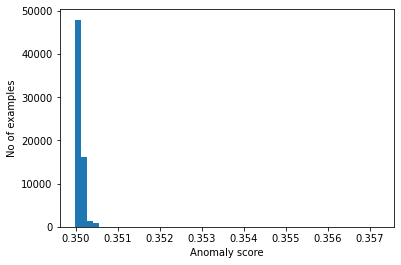

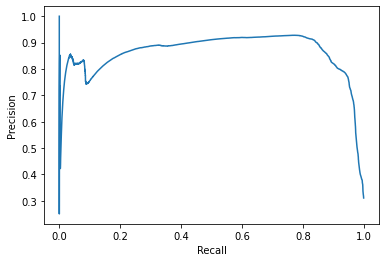

,AUC_precision_recall,F1,TNR,TPR,FNR,FPR
Synthetic,0.858144,0.872535,45393,16285,1832,2926


In [52]:
table = evaluate(Y_test, scores)

In [53]:
print(table.to_latex(index=True, multirow=True))

\begin{tabular}{lrrrrrr}
\toprule
{} &  AUC\_precision\_recall &        F1 &    TNR &    TPR &   FNR &   FPR \\
\midrule
Synthetic &              0.858144 &  0.872535 &  45393 &  16285 &  1832 &  2926 \\
\bottomrule
\end{tabular}

